# Lab 2

##### Team Members: Alex Lopez, Chris Haub, Erin McClure-Price

In [36]:
# Importing all packages and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
import glob
import os
import seaborn as sns #may not use
from sklearn.model_selection import StratifiedKFold

#Suppress futurewarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Set Figure Size
plt.rcParams["figure.figsize"] = (20,10)

## Data Preparation

### Part 1

***Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis.***

The first step was to load necessary packages and the dataset. In addition, we created a series of variables for indexing both the continuous and categorical variables.

In [27]:
#Import Dataset from github repo
bankData = pd.read_csv('bank-additional-full.csv', sep=';', na_values="unknown")
#Optional: Add in index column
#bankData.insert(0, 'Sample_ID', range(1,len(bankData)+1))

#Creating variables for indexing continuous and categorical variables
conCol = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
          'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

catCol = ['job', 'marital', 'education', 'housing', 'loan', 
          'contact', 'month', 'day_of_week', 'poutcome'] # Default is removed from this list because it is not used 

The next step was to drop entries with missing values, this removed #### rows leaving 30,488 rows for analysis as discussed in previous labs. In addition, we removed the 'default' column because it consisted of entirely 'no' responses and a total of 3 'yes' responses.

In [3]:
bankData2 = bankData.dropna()
#Remove 'default' column
bankData2 = bankData2.drop(['default'], axis=1)
bankData2.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Checking the shape of the data showed that we had a total of 30,488 rows and 21 attributes in our cleaned dataset.

In [4]:
bankData2.shape

(30488, 20)

We looked at the simple statistics of the continuous variables and noted that the means were close to the median, indicating that their distributions were fairly symmetrical.

In [35]:
#Getting basic statistical overview of continuous variables using the describe function
bankData2.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000,30488.000000
mean,39.030012,259.484092,2.521451,956.332295,0.194273,-0.071510,93.523311,-40.602263,3.459938,5160.813409
std,10.333529,261.714262,2.720150,201.373292,0.522788,1.610399,0.585374,4.789249,1.777231,75.158065
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,31.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.313000,5099.100000
50%,37.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.444000,-41.800000,4.856000,5191.000000
75%,45.000000,321.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,95.000000,4918.000000,43.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Looking at the target variable, y, we see that it is remarkably unbalanced.

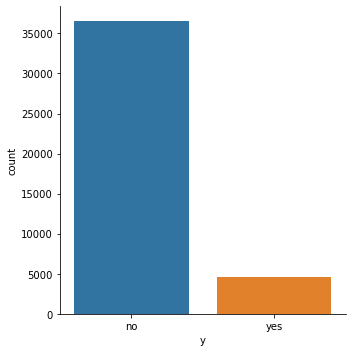

In [32]:
sns.catplot(x='y', data = bankData, kind = 'count')

In [6]:
display(bankData2.groupby("job").count())

,age,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
job,,,,,,,,,,,,,,,,,,,,
admin.,10422,10408,10173,9129,10195,10195,10422,10422,10422,10422,10422,10422,10422,10422,10422,10422,10422,10422,10422,10422
blue-collar,9254,9240,8800,6088,9014,9014,9254,9254,9254,9254,9254,9254,9254,9254,9254,9254,9254,9254,9254,9254
entrepreneur,1456,1453,1399,1155,1420,1420,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456,1456
housemaid,1060,1057,1018,741,1031,1031,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060
management,2924,2921,2801,2466,2853,2853,2924,2924,2924,2924,2924,2924,2924,2924,2924,2924,2924,2924,2924,2924
retired,1720,1715,1622,1327,1676,1676,1720,1720,1720,1720,1720,1720,1720,1720,1720,1720,1720,1720,1720,1720
self-employed,1421,1416,1392,1139,1381,1381,1421,1421,1421,1421,1421,1421,1421,1421,1421,1421,1421,1421,1421,1421
services,3969,3963,3819,3053,3868,3868,3969,3969,3969,3969,3969,3969,3969,3969,3969,3969,3969,3969,3969,3969
student,875,874,708,771,852,852,875,875,875,875,875,875,875,875,875,875,875,875,875,875


Performing One Hot encoding on the categorical variables and storing this as a separate dataset concatenated with the continuous variables.

In [28]:
#One hot encoding of ALL categorical variables
OneHotDF = pd.concat([pd.get_dummies(bankData2[col],prefix=col,drop_first=True) for col in catCol], axis=1)
#Combining with continuous variables from cleaned dataset
OneHotDF = pd.concat([bankData2.select_dtypes(exclude='object'),OneHotDF],axis=1)
OneHotDF.head()

#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/01.%20Pandas.ipynb

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0
6,59,139,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,1,0,0,0,1,0,0,0,1,0


Normalizing and finalizing Dataset

In [31]:
#Separating X values
x = OneHotDF
xVal = x.values

#Scaling values
scl_obj = StandardScaler()
xScaled = scl_obj.fit_transform(xVal)

### Part 2

***Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).***

The final dataset we used was removed of all rows with missing data mainly due to the large size of the original data set. This meant that rather than trying to impute categorical variables, we could simply remove those rows while still meeting our instance size requirements.



After the missing variables were removed, we one-hot-encoded the categorical features to be able to work with all numeric features. This format is required for certain models that we planned on utilizing later in the analysis.



Next, the data set was converted from a data frame to a list format. The data was converted into a list format to satisfy the cross validation training algorithim that required this type of data input.



Finally, the numeric, list format data set was scaled. This is required for classifiers like Random Forest and even moreso, K Nearest Neighbors.

## Modeling and Evaluation

### Part 1

***Choose and explain your evaluation metrics that you will use (i.e., accuracy,
precision, recall, F-measure, or any metric we have discussed). Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.***

### Part 2

***Choose the method you will use for dividing your data into training and
testing splits (i.e., are you using Stratified 10-fold cross validation? Why?). Explain why
your chosen method is appropriate or use more than one method as appropriate. For example, if you are using time series data then you should be using continuous training and testing sets across time.***

We will be using stratified sampling in our data combined with 10-fold cross validation

In [9]:
def getCP(column):
    xCount = column.value_counts()
    xPercentages = xCount/len(column)
    outData = pd.DataFrame()
    outData['Counts'] = xCount
    outData['Percent of Total'] = xPercentages
    return outData

print("Percentages for Target variable, Y: \n\n",getCP(bankData2['y']),"\n\n")

Percentages for Target variable, Y: 

      Counts  Percent of Total
no    26629          0.873426
yes    3859          0.126574 




As seen above, the target variable of our data set is imbalanced with ~87% no responses. With this imbalance in mind, we chose to procede with stratified sampling when performing training and test splits. In combination with this sampling, we chose to perform K-fold cross validation

In [32]:
randomState = 777
cv = StratifiedKFold(n_splits=2, random_state = randomState)

y = bankData2['y']

for train_indices, test_indices in cv.split(X,Y): 
    xTrain = x[train_indices]
    yTrain = y[train_indices]
    
    

NameError: name 'StratifiedKFold' is not defined

### Part 3

***Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). Two modeling techniques must be new (but the third could be SVM or logistic regression). Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!***

### Part 4

***Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.***

### Part 5

***Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another? Is the difference significant with 95% confidence? Use proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.***

### Part 6

***Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.***

## Deployment

***How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)? How would you measure the model's value if it was used by these parties? How would your deploy your model for interested parties? What other data should be collected? How often would the model need to be updated, etc.?***

## Exceptional Work

You have free reign to provide additional analyses. One idea: grid search parameters in a parallelized fashion and visualize the performances across attributes. Which parameters are most significant for making a good model for each classification algorithm?